In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.data import AUTOTUNE
# from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, Activation, Rescaling
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential as SequentialModel
# import keras_tuner as kt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
# import itertools

import os
# import time

from pathlib import Path

from datasets import dataset_labels_to_dataframe

tf.random.set_seed(5263)
tf.__version__

'2.14.0'

In [2]:
eval_dataset_path = Path("") / "datasets" / "data" / "EVAL-perfect-human-expert-15-played"
eval_df = dataset_labels_to_dataframe(eval_dataset_path, "8_zone_presence_labels.csv")

len(eval_df.index)

C:\Users\Zestyy\OneDrive - MMU\Programming\Python\Tensorflow\WA.M.AI\datasets\data\dataframe_builder.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_path = (data_folder / row[0]).resolve()


256

In [3]:
eval_file_names = eval_df["file_name"].values

eval_file_names[0]

'C:\\Users\\Zestyy\\OneDrive - MMU\\Programming\\Python\\Tensorflow\\WA.M.AI\\datasets\\data\\EVAL-perfect-human-expert-15-played\\perfect-human-expert-15-played-0000000007.png'

In [4]:
eval_labels = eval_df.drop("file_name", axis=1)

eval_labels.head()

,b1,b2,b3,b4,b5,b6,b7,b8
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False


In [5]:
eval_dataset = tf.data.Dataset.from_tensor_slices((eval_file_names, eval_labels))
eval_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.bool, name=None))>

In [6]:
# Normalise image values to 0-1 from 0-255, and ensure all images are 400x400
IMG_SIZE = (400, 400, 3)
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  layers.Rescaling(1./255)
])

def read_image(image_path, labels):
    # Read data from file path and resize to 400x400
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = resize_and_rescale(image)
    # `decode_png` does not state the size of the image, so we force it here`
    # image.set_shape([400, 400, 3])
    # In a normal dataset, the first dimension states how many samples are in the set. 
    # Since teach tensor set here represents 1 sample, we insert a new dimension (which will have length 1) 
    # to state that there is 1 sample
    image = tf.expand_dims(image, 0)
    labels = [labels]
    
    return image, labels

eval_dataset = eval_dataset.map(read_image)
eval_dataset

<_MapDataset element_spec=(TensorSpec(shape=(1, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 8), dtype=tf.bool, name=None))>

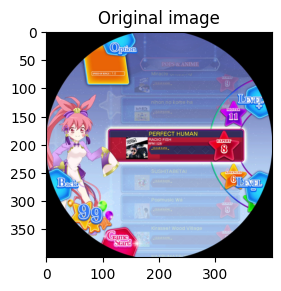

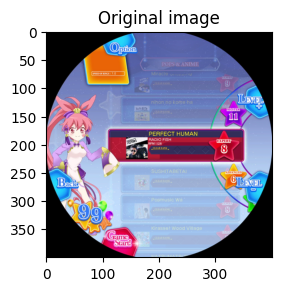

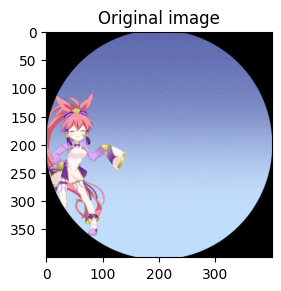

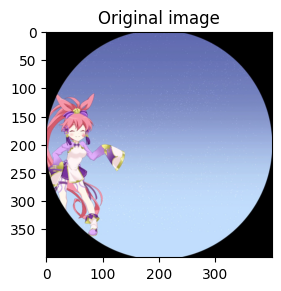

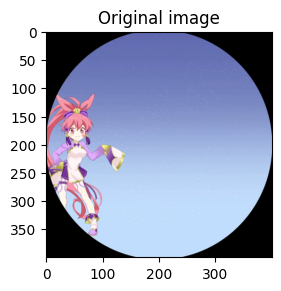

In [7]:
# Visualise the first 5 items in the dataset to ensure that augmentation works as expected
def visualize(original):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

items = eval_dataset.take(5)

for i in items.as_numpy_iterator():
    visualize(i[0][0])

In [8]:
wamai_model = tf.keras.models.load_model("models/WA.M.AI FiNALE proto colab 1/WA.M.AI-p-finale-epoch25-l5.27-acc0.4492.keras")

wamai_model.summary()

ValueError: Layer 'conv2d_8' expected 2 variables, but received 0 variables during loading. Expected: ['conv2d_8/kernel:0', 'conv2d_8/bias:0']

In [ ]:
preds = wamai_model.predict(eval_dataset)
preds

In [ ]:
bool_preds = []
for pred_set in preds:
    bool_preds.append([])
    for pred in pred_set:
        bool_preds[-1].append(pred >= 0.5)

# def preds_to_bool(pred):
#     return pred >= 0.5
# 
# bool_preds = preds.vectorize(preds_to_bool)(preds)

np.array(bool_preds)

In [ ]:
# Visualise the first 5 items in the dataset to ensure that augmentation works as expected
def visualize_predictions(original, labels):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title(f'Labels - {labels}')
  plt.imshow(original)

items = eval_dataset.take(eval_dataset.cardinality())

# crudely sample a tenth of the dataset

for count, i in enumerate(items.as_numpy_iterator()):
    if random.randint(0, 10) == 0:
        visualize_predictions(i[0][0], bool_preds[count])